In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

base_path  = r"C:\Users\maysa\Documents\retail_eda\data"
train_path = os.path.join(base_path, "train.csv")
test_path  = os.path.join(base_path, "test.csv")
stores_path = os.path.join(base_path, "stores.csv")
features_path = os.path.join(base_path, "features.csv")

train_df    = pd.read_csv(train_path)
test_df     = pd.read_csv(test_path)
stores_df   = pd.read_csv(stores_path)
features_df = pd.read_csv(features_path)

tm['Year'] = tm['Date'].dt.year
tm['Month'] = tm['Date'].dt.month
tm['Week'] = tm['Date'].dt.isocalendar().week
tm['DayOfWeek'] = tm['Date'].dt.dayofweek

plt.style.use("seaborn-v0_8")

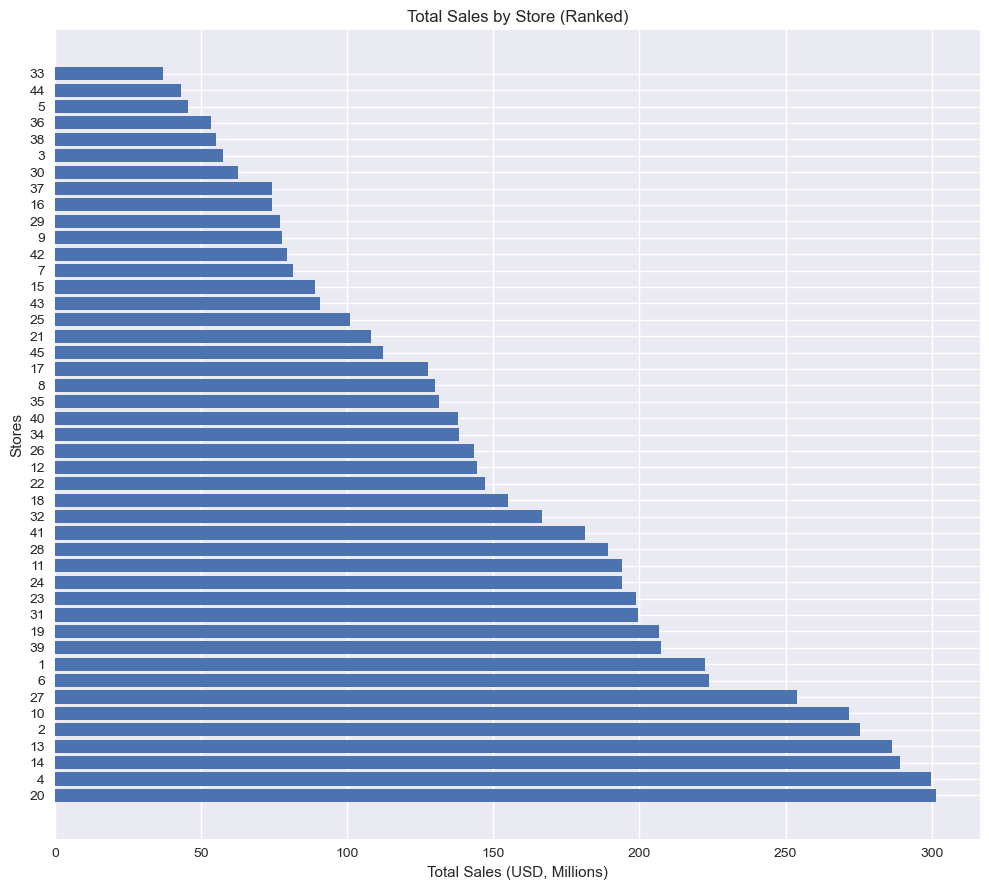

In [52]:
# BUSINESS QUESTION: Which stores drive the most total revenue across the full period?
# HOW THIS CHART ANSWERS IT: We sum Weekly_Sales by Store and rank.
# ANSWER: 
# A small set of stores contribute a disproportionate share of revenue (long-tail pattern).


total = tm['Weekly_Sales'].groupby(tm['Store']).sum().sort_values(ascending=False)
total_mil = total / 1000000 #scaled to millions

fig, ax = plt.subplots(figsize=(10,9))

ax.barh(total_mil.index.astype(str),
        total_mil.values)

ax.set_title("Total Sales by Store (Ranked)")
ax.set_xlabel("Total Sales (USD, Millions)")
ax.set_ylabel("Stores")
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()


Text(0, 0.5, 'Store')

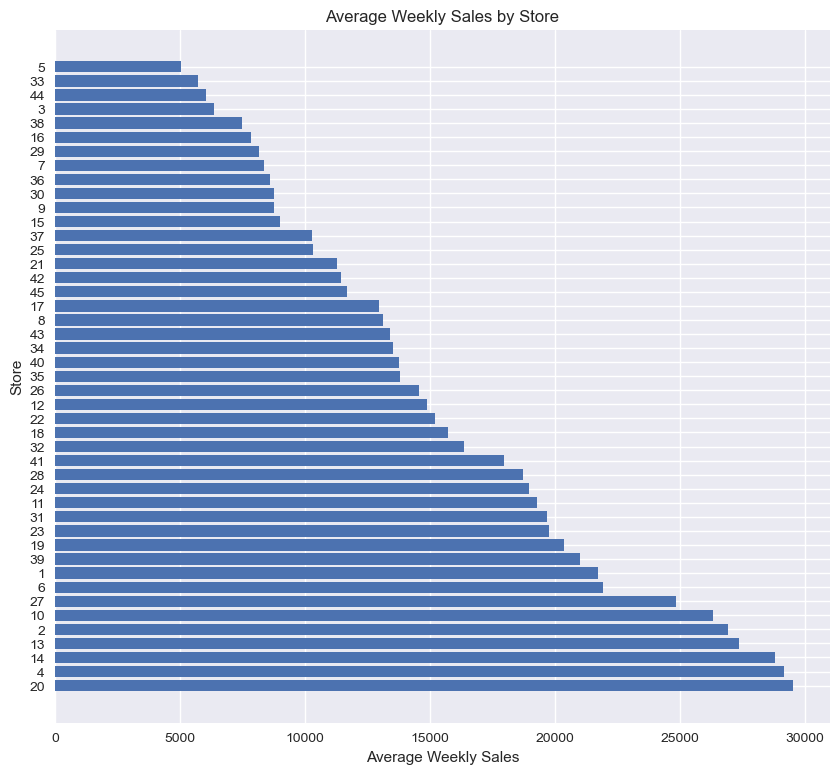

In [7]:
# BUSINESS QUESTION: Which stores have the highest **typical** weekly sales (baseline run-rate)?
# HOW THIS CHART ANSWERS IT: We compute the mean of Weekly_Sales for each Store across the full period,then sort and plot
# ANSWER: The ranking highlights the stores with the strongest week-in, week-out performance.
avg_weekly = tm.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,9))

ax.barh(avg_weekly.index.astype(str),
        avg_weekly.values)

ax.set_xlabel('Average Weekly Sales (USD)')
ax.set_title('Average Weekly Sales by Store')
ax.set_ylabel('Store')


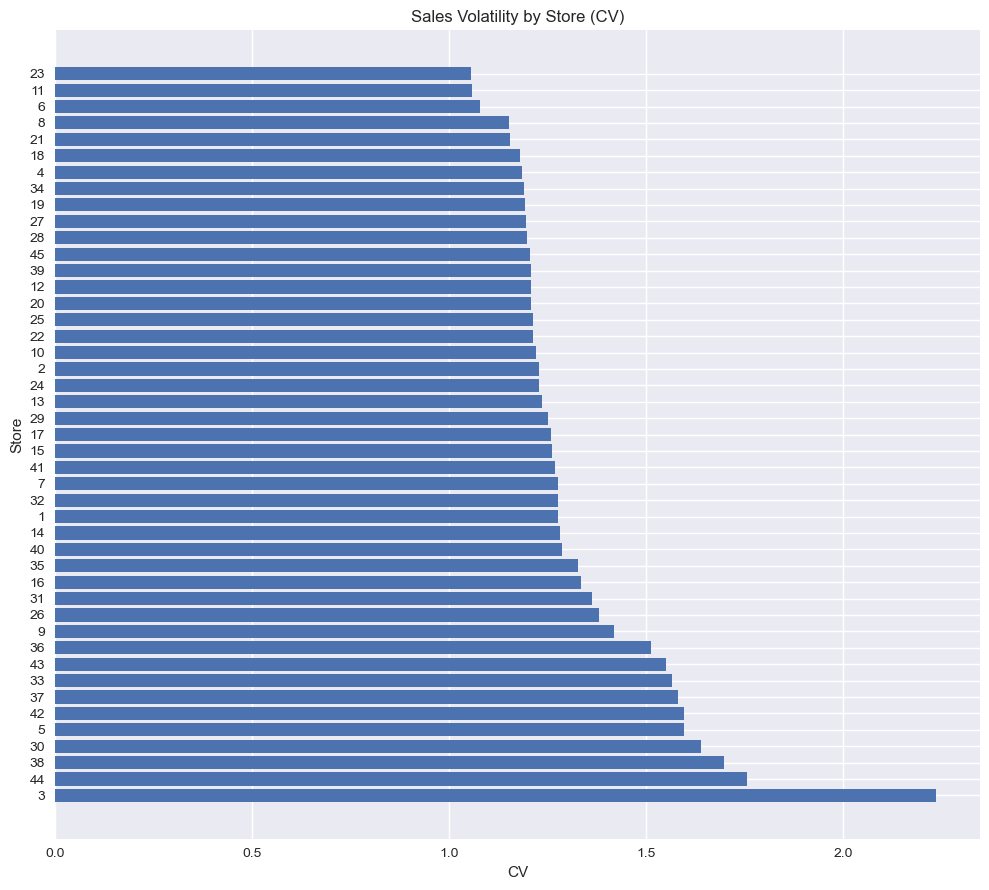

In [8]:
# BUSINESS QUESTION: Which stores are the most volatile (hardest to forecast) relative to their scale?
# HOW THIS CHART ANSWERS IT: We compute the coefficient of variation per Store: CV = std / mean.
# ANSWER:
# A few stores exhibit high CV (spiky demand). They need tighter replenishment
# controls and closer promo/holiday planning; low-CV stores are steady “baseline” volume.
cv_df = (tm.groupby('Store')['Weekly_Sales'].agg(mean='mean', std='std'))
cv_df['CV'] = cv_df['std'] / cv_df['mean']
cv_sorted = cv_df['CV'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,9))

ax.barh(cv_sorted.index.astype(str),
        cv_sorted.values)

ax.set_title('Sales Volatility by Store (CV)')
ax.set_xlabel('CV')
ax.set_ylabel('Store')

plt.tight_layout()



Text(0.5, 1.0, 'Store Leaderboard: Average Weekly Sales (4 Weeks)')

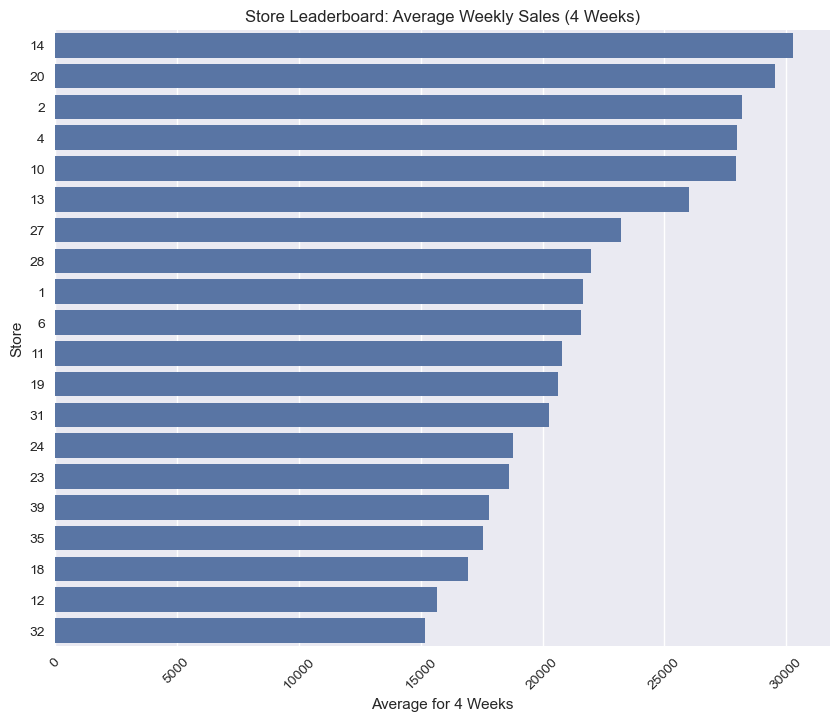

In [9]:
# BUSINESS QUESTION: Over a specific 4-week window, which stores performed best on average?
# HOW THIS CHART ANSWERS IT: We filter the 4-week range and compute mean Weekly_Sales per Store.
# ANSWER: 
# Performance spreads meaningfully across stores even in a short window,
# The same leaders from the full-period view generally remain strong.
df = tm[["Store", "Date", "Weekly_Sales"]]

four_weekstat = df.loc[(df["Date"] >= "2010-02-05") &
                       (df["Date"] <= "2010-03-05")]
final = four_weekstat.groupby( 'Store', as_index=False)['Weekly_Sales'].mean().rename(
    columns={'Weekly_Sales':'Mean_4w'}).sort_values('Mean_4w', ascending=False).head(20)

plt.figure(figsize=(10,8))

g = sns.barplot(data=final,
                x='Mean_4w',
                y=final['Store'].astype(str))

g.set_title("Store Leaderboard: Average Weekly Sales (4 Weeks)")
g.set(xlabel="Average for 4 Weeks (USD)",
      ylabel="Store")
plt.tick_params(axis='x', rotation=45)



Text(0.5, 1.02, 'YoY Sales Growth by Store (%), 2011 vs 2010')

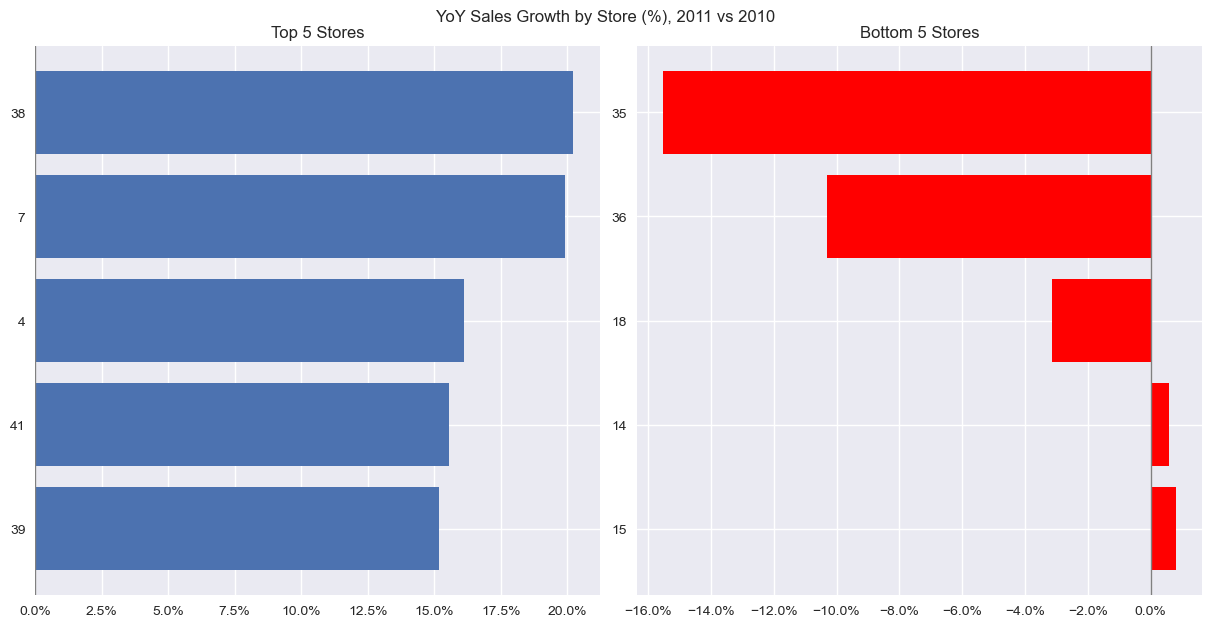

In [10]:
# BUSINESS QUESTION: Which stores grew the fastest year-over-year, and which declined?
# HOW THIS CHART ANSWERS IT : We compute (2011 sum – 2010 sum) / 2010 sum for each Store and show top/bottom 5.
# ANSWER: 
# Clear winners and laggards emerge. Winners likely benefited from local factors or execution;

from matplotlib.ticker import PercentFormatter
dx = tm[["Store", "Date", "Weekly_Sales"]]

prev_year = dx.loc[(dx["Date"] >= "2010-01-01") &
                    (dx["Date"] <= "2010-12-31")]
prev_year_sum = prev_year.groupby('Store',as_index=False)['Weekly_Sales'].sum()

current_year = dx.loc[(dx["Date"] >= "2011-01-01") &
                    (dx["Date"] <= "2011-12-31")]
current_year_sum = current_year.groupby('Store', as_index=False)['Weekly_Sales'].sum()

current_year_sum['Yoy'] = (current_year_sum['Weekly_Sales'] - prev_year_sum['Weekly_Sales']) / prev_year_sum['Weekly_Sales']
current_year_sum1 = current_year_sum.sort_values(by='Yoy', ascending=False).head(5)
current_year_sum2 = current_year_sum.sort_values(by='Yoy', ascending=True).head(5)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].cla()
ax[0].barh(current_year_sum1['Store'].astype(str), current_year_sum1['Yoy'])
ax[1].cla()
ax[1].barh(current_year_sum2['Store'].astype(str), current_year_sum2['Yoy'], color='r')

ax[0].set_title("Top 5 Stores")
ax[1].set_title("Bottom 5 Stores")

ax[0].axvline(0, color='gray', linewidth=1)
ax[1].axvline(0, color='gray', linewidth=1)

ax[0].xaxis.set_major_formatter(PercentFormatter(1.0))
ax[1].xaxis.set_major_formatter(PercentFormatter(1.0))

ax[1].invert_yaxis()
ax[0].invert_yaxis()

fig.suptitle('YoY Sales Growth by Store (%), 2011 vs 2010', y=1.02)

Text(0.5, 1.0, 'Dots = stores; color = Type (A/B/C); size = Store Size (sq ft)')

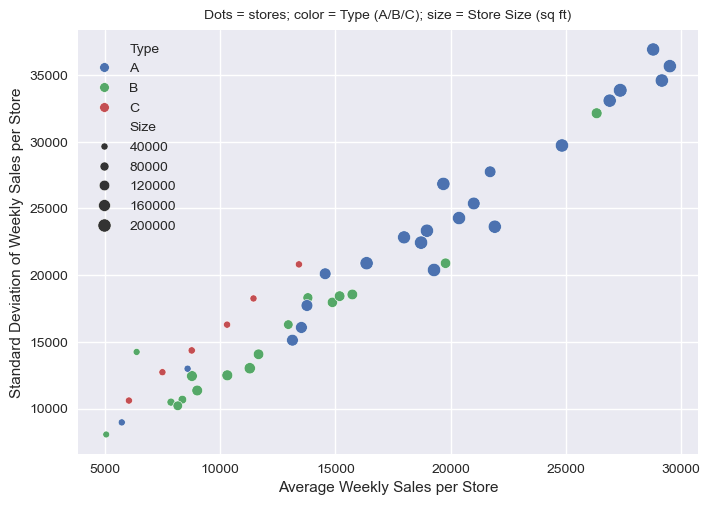

<Figure size 1000x800 with 0 Axes>

In [42]:
# BUSINESS QUESTION: How does variability (std) grow with scale (mean) across stores?
# HOW THIS CHART ANSWERS IT: One dot per store: x=mean Weekly_Sales, y=std of Weekly_Sales.
# ANSWER:
# Variance increases with sales level, comparing volatility fairly across stores
# is better using CV (std/mean), which we show in the risk–return chart.
df = tm.groupby(['Store', 'Type', 'Size'])['Weekly_Sales'].agg(mean='mean', std='std')

ax = plt.gca()
plt.figure(figsize=(10,8))

g = sns.scatterplot(data=df,
                    x='mean',
                    y='std',
                    hue='Type',
                    size='Size')

g.set_title('Risk–Return by Store — Mean vs Std of Weekly Sales')
g.set(xlabel= 'Average Weekly Sales per Store (USD)',
     ylabel=  'Standard Deviation of Weekly Sales per Store')
ax.set_title('Dots = stores; color = Type (A/B/C); size = Store Size (sq ft)',
             fontsize=10, pad=8)


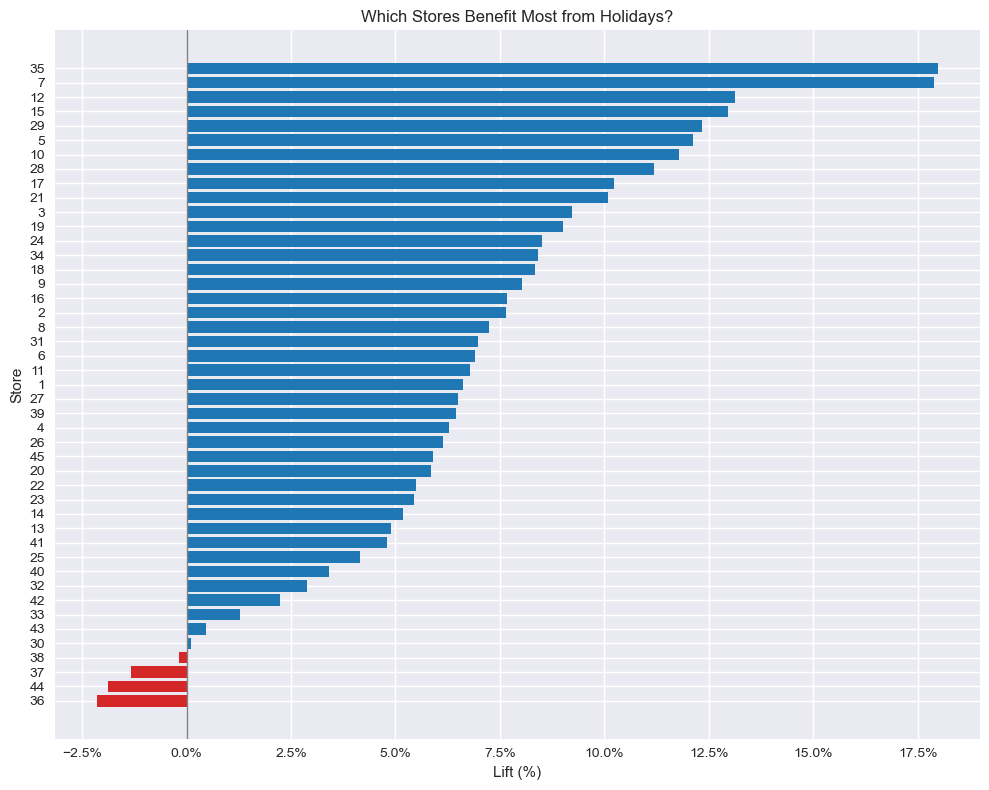

In [43]:
# BUSINESS QUESTION: How much do holidays lift (or reduce) sales by store?
# HOW THIS CHART ANSWERS IT: Lift% = (holiday mean – non-holiday mean) / non-holiday mean per Store; bars colored by sign.
# ANSWER: Most stores see positive holiday lift; a few show flat/negative lift → investigate
from matplotlib.ticker import PercentFormatter

df = tm[['Store', 'Weekly_Sales', 'IsHoliday']]

df_t = df[df['IsHoliday'] == True] 

df_f = df[df['IsHoliday'] == False] 
df_t_mean = df_t.groupby('Store')['Weekly_Sales'].mean().reset_index()
df_f_mean = df_f.groupby('Store')['Weekly_Sales'].mean().reset_index()

df_t_mean.columns= ['Store', 'HolidayMean']
df_f_mean.columns= ['Store', 'NonHolidayMean']

store_stats = df_t_mean.merge(df_f_mean, on='Store')
store_stats['Lift%'] = (store_stats['HolidayMean'] - store_stats['NonHolidayMean']) / store_stats['NonHolidayMean'] * 100
store_stats = store_stats.sort_values(by='Lift%', ascending = True)


colors = np.where(store_stats['Lift%'] >= 0, 'tab:blue', 'tab:red')

fig, ax= plt.subplots(figsize=(10,8))

ax.barh(store_stats['Store'].astype(str),
        store_stats['Lift%'],
        color=colors)

ax.axvline(0, color='gray', linewidth=1)
plt.title('Which Stores Benefit Most from Holidays?')
ax.set_xlabel('Lift (%)')
ax.set_ylabel('Store')
ax.xaxis.set_major_formatter(PercentFormatter(100))
plt.tight_layout()



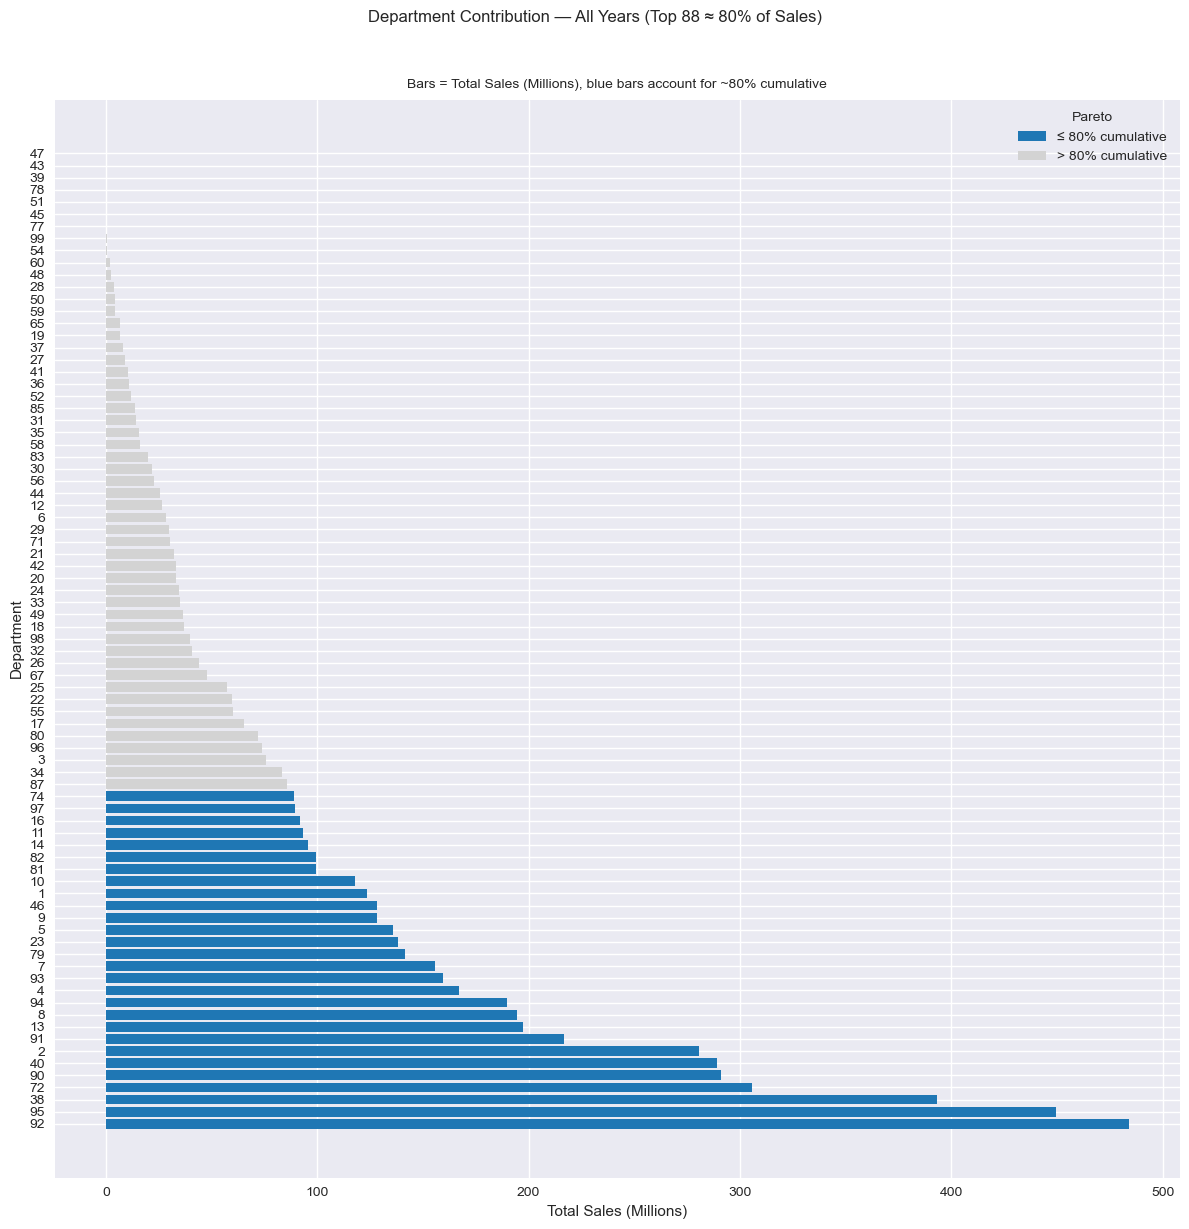

In [13]:
# BUSINESS QUESTION: Which departments account for ~80% of sales?
# HOW THIS CHART ANSWERS IT: We rank departments by total sales and color bars up to the 80% cumulative cutoff.
# ANSWER:
# Roughly the top 88 departments generate ~80% of revenue.

from matplotlib.patches import Patch

df = tm[['Dept', 'Weekly_Sales']]
df = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
df = df / 1000000 

cum = df.cumsum() / df.sum()
cut_idx = int((cum >= 0.80).idxmax())

colors = np.where(cum.values <= 0.80, 'tab:blue', 'lightgray')
fig, ax = plt.subplots(figsize=(12,12))
ax.barh(df.index.astype(str), df.values, color=colors)
ax.set_xlabel('Total Sales (Millions)')
ax.set_ylabel('Department')

fig.suptitle(f'Department Contribution — All Years (Top {cut_idx+1} ≈ 80% of Sales)',
             y=1.02)
ax.set_title('Bars = Total Sales (Millions), blue bars account for ~80% cumulative', 
             fontsize=10,
             pad=8)

legend_handles = [
    Patch(facecolor='tab:blue',
          label='≤ 80% cumulative'),
    Patch(facecolor='lightgray', 
          label='> 80% cumulative'),
]
ax.legend(handles=legend_handles,
          loc='upper right', 
          frameon=False, 
          title='Pareto')
plt.tight_layout()



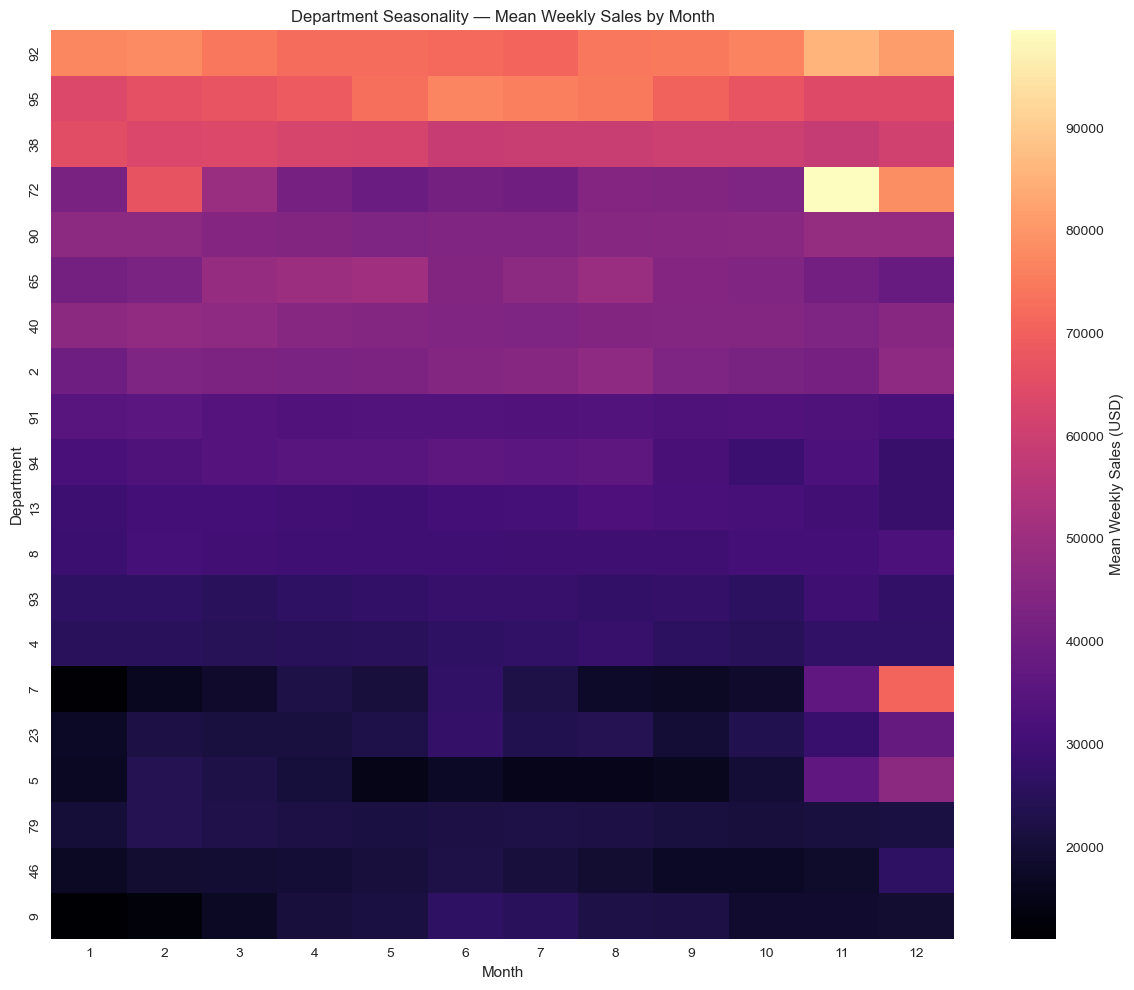

In [50]:
# BUSINESS QUESTION: When does each department peak during the year?
# HOW THIS CHART ANSWERS IT: We plot mean Weekly_Sales by Deptartment and Month (1–12).
# ANSWER:
# Holiday-sensitive departments spike in Nov–Dec; some are summer-heavy (Jun–Aug),
# several are flat and provide steady baseline volume.
df = tm[['Dept', 'Month', 'Weekly_Sales']]
df = df.groupby(['Dept', 'Month'])['Weekly_Sales'].mean().unstack(fill_value=0)

df_sorted = (df.assign(mean=df.mean(axis=1)).sort_values('mean', ascending=False).drop(columns='mean').head(30))

plt.figure(figsize=(12, 10))
sns.heatmap(df_sorted,
            cmap='magma',
            cbar_kws={'label': 'Mean Weekly Sales (USD)'})

plt.title('Department Seasonality — Mean Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Department')
plt.tight_layout()


[Text(0.5, 0, 'Size (Square Feet)'), Text(0, 0.5, 'Average Weekly Sales')]

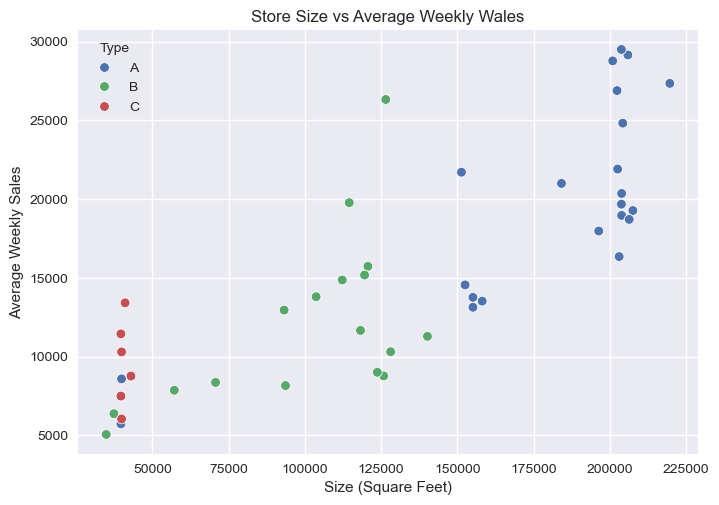

In [51]:
# BUSINESS QUESTION: Do larger stores sell more, and do Types (A/B/C) behave differently?
# HOW THIS CHART ANSWERS IT: One dot per store: x=Size (sq ft), y=average Weekly_Sales, color by Type.
# ANSWER:
# Bigger stores generally deliver higher average sales with hints of diminishing returns at the top end.
# A few large, underperforming stores stand out as diagnostics targets.
df_sorted = tm.groupby('Store', as_index=False)[['Weekly_Sales']].mean().rename(columns={'Weekly_Sales':'AvgwWeklySales'})
df_final = df_sorted.merge(tm[['Store','Size','Type']], on='Store', how='left')
df_distinct= df_final.drop_duplicates()

g = sns.scatterplot(data=df_distinct,
                    x='Size', 
                    y='AvgwWeklySales', 
                    hue='Type')
g.set_title('Store Size vs Average Weekly Wales')
g.set(xlabel='Size (Square Feet)',
      ylabel='Average Weekly Sales')


    Store          mean        cv Type
22     23  19776.180881  1.056679    B
10     11  19276.762751  1.057849    A
5       6  21913.243624  1.078500    A
17     18  15733.313136  1.179431    B
3       4  29161.210415  1.185948    A
    Store         mean        cv Type
2       3  6373.033983  2.236146    B
43     44  6038.929814  1.756846    C
37     38  7492.478460  1.699485    C
29     30  8764.237719  1.638969    C
4       5  5053.415813  1.596588    B


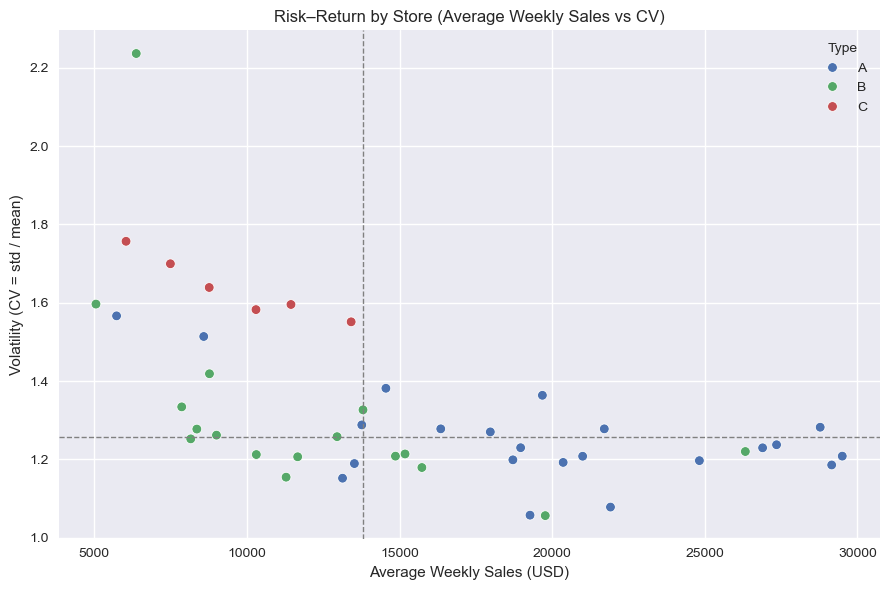

In [49]:
# BUSINESS QUESTION: Which stores are steady “workhorses” vs “spiky” risks?
# HOW THIS CHART ANSWERS IT: One dot per store: x=average Weekly_Sales, y=CV (std/mean). Median lines create quadrants.
# ANSWER:
# Bottom-right quadrant = high sales with low volatility (workhorses to scale).
# Top-left/top-right = spiky stores to monitor.
df1 = tm.groupby(['Store', 'Type'], as_index=False)['Weekly_Sales'].agg(['mean','std'])
df1['cv'] = df1['std'] / df1['mean']

mean_md, cv_md = df1['mean'].median(), df1['cv'].median()

plt.figure(figsize=(9,6))
sns.scatterplot(x='mean',
                y='cv', data=df1, 
                hue='Type')

plt.axvline(mean_md, color='gray',
            linestyle='--',
            linewidth=1)
plt.axhline(cv_md, color='gray',
            linestyle='--', 
            linewidth=1)

plt.title('Risk–Return by Store (Average Weekly Sales vs CV)')
plt.xlabel('Average Weekly Sales (USD)')
plt.ylabel('Volatility (CV = std / mean)')

df1.head()

df_top = df1[['Store', 'mean', 'cv', 'Type']]
df_top_5 = df_top[(df_top['mean'] >= mean_md) & (df_top['cv'] <= cv_md)].sort_values(['cv','mean']).head(5)
df_bottom_5 = df_top.sort_values('cv', ascending=False).head(5)

print(df_top_5)
print(df_bottom_5)
plt.tight_layout()